# Configurações Iniciais

    - Importando bibliotecas necessárias

In [1]:
import random
import os
import numpy as np
import torch
import shutil
import torchvision
import torchvision.models as models
from torchvision.transforms import v2 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from tqdm import tqdm
import seaborn as sns

    - Definindo a seed
    - Setando o device

In [2]:
def set_seed(seed=1234):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

---

# Definindo o Dataset
    - Definindo as imagens
    - Realizando a normalização
    - Dividindo entre treino e teste

In [3]:
img_size = (256,256)

transformations = v2.Compose([
    v2.Resize(img_size), 
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=(0, 180)),
    v2.RandomPerspective(p=0.5),  
    #v2.RandomEqualize(),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset_dir = 'assets'

checkpoints_dir = ".ipynb_checkpoints"

if os.path.exists(checkpoints_dir):
    if os.path.isdir(checkpoints_dir):
        shutil.rmtree(checkpoints_dir)  
    else:
        os.remove(checkpoints_dir)
print(os.listdir(dataset_dir))

dataset = datasets.ImageFolder(root=dataset_dir, transform=transformations)
print(os.listdir(dataset_dir))

['CoralFalsa', 'CoralVerdadeira']
['CoralFalsa', 'CoralVerdadeira']


In [5]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [6]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

---

# Definindo Funções

    - Validação
    - Treino
    - Acurácia
    - Matriz de Confusão

In [7]:
def validation(model, loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss += loss.item()
    return val_loss/len(loader)

In [8]:
def train(model, trainloader, testloader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for data in tqdm(trainloader):
            images, labels = data
            model.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        val_loss = validation(model, testloader, criterion)
        print(f'Epoch: {epoch+1} | Loss: {running_loss/len(trainloader)} | Val Loss: {val_loss}')

In [9]:
def accuracy(model, loader):
    model.eval()
    corrected = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrected += (predicted == labels).sum().item()
    return corrected * 100 // total

In [10]:
def confusion_matrix(model, loader):
    model.eval()
    confusion_matrix = np.zeros((2,2))
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            for i in range(labels.size(0)):
                confusion_matrix[labels[i].item()][predicted[i].item()] += 1
    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Coral Falsa', 'Coral Verdadeira'], yticklabels=['Coral Falsa', 'Coral Verdadeira'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Label')
    return ax

---

# Treinando o Modelo

    - Utilizando a resnet
    - Congelar pesos das camadas
    - Treinar com o dados

In [11]:
resnet = torchvision.models.resnet50(weights = torchvision.models.ResNet50_Weights.DEFAULT)

In [12]:
resnet.fc = nn.Linear(2048,2)

In [13]:
for name, params in resnet.named_parameters():
    if name not in ('fc.weight', 'fc.bias'):
        params.requires_grad = False

In [14]:
resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
epochs = 30

In [15]:
train(resnet, train_loader, test_loader, optimizer, criterion, epochs)

100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.88s/it]


Epoch: 1 | Loss: 0.7101018726825714 | Val Loss: 0.6954783201217651


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.88s/it]


Epoch: 2 | Loss: 0.6977740824222565 | Val Loss: 0.6975124478340149


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.89s/it]


Epoch: 3 | Loss: 0.7072145342826843 | Val Loss: 0.6937329173088074


100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.27s/it]


Epoch: 4 | Loss: 0.6275622546672821 | Val Loss: 0.6972333192825317


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.80s/it]


Epoch: 5 | Loss: 0.6589192152023315 | Val Loss: 0.6852626204490662


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.82s/it]


Epoch: 6 | Loss: 0.6064645648002625 | Val Loss: 0.6545413136482239


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.91s/it]


Epoch: 7 | Loss: 0.6482284665107727 | Val Loss: 0.6858372688293457


100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.50s/it]


Epoch: 8 | Loss: 0.6469758749008179 | Val Loss: 0.6760251522064209


100%|█████████████████████████████████████████████| 2/2 [00:09<00:00,  4.70s/it]


Epoch: 9 | Loss: 0.6384648978710175 | Val Loss: 0.7023912668228149


100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.24s/it]


Epoch: 10 | Loss: 0.6410771012306213 | Val Loss: 0.6745179295539856


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.93s/it]


Epoch: 11 | Loss: 0.5922394692897797 | Val Loss: 0.6941505074501038


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.88s/it]


Epoch: 12 | Loss: 0.5589396357536316 | Val Loss: 0.7118715047836304


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.95s/it]


Epoch: 13 | Loss: 0.5734210908412933 | Val Loss: 0.6825165152549744


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.81s/it]


Epoch: 14 | Loss: 0.5223716795444489 | Val Loss: 0.6756036281585693


100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.01s/it]


Epoch: 15 | Loss: 0.5811575651168823 | Val Loss: 0.6885223388671875


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.97s/it]


Epoch: 16 | Loss: 0.4791285842657089 | Val Loss: 0.6480183601379395


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.99s/it]


Epoch: 17 | Loss: 0.47333472967147827 | Val Loss: 0.6812296509742737


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.99s/it]


Epoch: 18 | Loss: 0.5072892010211945 | Val Loss: 0.7006173133850098


100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.04s/it]


Epoch: 19 | Loss: 0.6277611553668976 | Val Loss: 0.6450542211532593


100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.01s/it]


Epoch: 20 | Loss: 0.511411264538765 | Val Loss: 0.6337088346481323


100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.05s/it]


Epoch: 21 | Loss: 0.46244651079177856 | Val Loss: 0.6294596195220947


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.99s/it]


Epoch: 22 | Loss: 0.48187707364559174 | Val Loss: 0.6438301205635071


100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.18s/it]


Epoch: 23 | Loss: 0.551234558224678 | Val Loss: 0.6255714893341064


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.97s/it]


Epoch: 24 | Loss: 0.4423818290233612 | Val Loss: 0.6403633952140808


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.96s/it]


Epoch: 25 | Loss: 0.5257246643304825 | Val Loss: 0.6733671426773071


100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.09s/it]


Epoch: 26 | Loss: 0.5050898641347885 | Val Loss: 0.6335931420326233


100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.01s/it]


Epoch: 27 | Loss: 0.5617594420909882 | Val Loss: 0.7283700108528137


100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.27s/it]


Epoch: 28 | Loss: 0.5694305151700974 | Val Loss: 0.6587698459625244


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.95s/it]


Epoch: 29 | Loss: 0.43450695276260376 | Val Loss: 0.6741204261779785


100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.02s/it]


Epoch: 30 | Loss: 0.532621294260025 | Val Loss: 0.6952393651008606


A rede atinge: 61% de acurácia


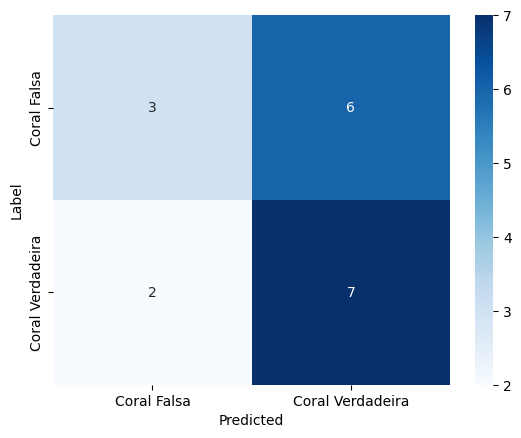

In [16]:
print(f'A rede atinge: {accuracy(resnet, test_loader)}% de acurácia')
conf_mat = confusion_matrix(resnet, test_loader)

---

# Comparando os Modelos

    - Primeiro nós precisamos fazer os outros modelos né kk


In [17]:
def predict(model, image):
    prediction = model(torch.unsqueeze(image, 0).to(device))
    result = torch.argmax(prediction)
    return 'Coral Verdadeira' if result == 0 else 'Coral Falsa'

In [18]:
image_index = 20
image = test[image_index][0]
label = 'Coral Falsa' if test[image_index][1] else 'Coral Verdadeira'
imshow(image)
print(label)

NameError: name 'test' is not defined

In [ ]:
print(f'Real Label: {label}')
print(f'Resnet Prediction: {predict(resnet, image)}')

In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF

x = Image.open('teste.jpg').convert('RGB')
x = transformations(x)

In [ ]:
print(f'Resnet Prediction: {predict(resnet, x)}')